In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *
from fastai.column_data import *

In [3]:
path='data/ml-latest-small/'

In [1]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

NameError: name 'pd' is not defined

In [5]:
u_uniq = ratings.userId.unique()
user2idx = {o:i for i,o in enumerate(u_uniq)}
ratings.userId = ratings.userId.apply(lambda x: user2idx[x])

m_uniq = ratings.movieId.unique()
movie2idx = {o:i for i,o in enumerate(m_uniq)}
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x])

n_users=int(ratings.userId.nunique())
n_movies=int(ratings.movieId.nunique())

### pytorch class

In [6]:
class EmbeddingDotProd(nn.Module):
    # nn.Module inherits from pytorch module to get all the awesom pytorch
    def __init__(self, n_users, n_movies):
        super().__init__()
        # creating the embedding matrices layer -> Embedding(rows, cols)
        # creates 2 randomly initialised arrays 
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        # change the random initialised nums so that it is not to far away
        # i.e if its too high then gradient descent starts from further away -> longer
        # should set weight equal a normal dist w std deviation proportional to number of things in previous layer
        self.u.weight.data.uniform_(0, 0.05)
        self.m.weight.data.uniform_(0, 0.05)
    
    def forward(self, cats, conts):
        # grab idxs for vars
        users, movies = cats[:,0], cats[:,1]
        # do array lookup on embedding matrics
        # does this a mini batch at a time does not require a loop
        # dont loop manualy
        u,m = self.u(users),self.m(movies)
        #return dot product
        return (u*m).sum(1)
        

In [8]:
# ??EmbeddingDotProd

In [9]:
x = ratings.drop(['rating', 'timestamp'], axis=1)

y = ratings['rating']

n_factors = 50
val_idxs = get_cv_idxs(len(ratings))


In [10]:
# Fast ai data loader, basically a python generator
data = ColumnarModelData.from_data_frame(path, val_idxs, x, y, ['userId', 'movieId'], 64)

In [15]:
weight_decay=1e-5  
model = EmbeddingDotProd(n_users, n_movies).cuda()

opt = optim.SGD(model.parameters(), 1e-1, weight_decay=weight_decay, momentum=0.9)

### RAW `fit.()` looping training function



In [12]:

def fit(model, data, epochs, opt, crit, metrics=None, callbacks=None, stepper=Stepper, **kwargs):
    """ Fits a model

    Arguments:
       model (model): any pytorch module
           net = to_gpu(net)
       data (ModelData): see ModelData class and subclasses
       opt: optimizer. Example: opt=optim.Adam(net.parameters())
       epochs(int): number of epochs
       crit: loss function to optimize. Example: F.cross_entropy
    """
    stepper = stepper(model, opt, crit, **kwargs)
    metrics = metrics or []
    callbacks = callbacks or []
    avg_mom=0.98
    batch_num,avg_loss=0,0.
    for cb in callbacks: cb.on_train_begin()
    names = ["epoch", "trn_loss", "val_loss"] + [f.__name__ for f in metrics]
    layout = "{!s:10} " * len(names)
    
    num_batch = len(data.trn_dl)
    if epochs<1:
        num_batch = int(num_batch*epochs)
        epochs = 1

    for epoch in tnrange(epochs, desc='Epoch'):
        stepper.reset(True)
        t = tqdm(iter(data.trn_dl), leave=False, total=num_batch)
        i = 0
        for (*x,y) in t:
            batch_num += 1
            for cb in callbacks: cb.on_batch_begin()
            loss = stepper.step(V(x),V(y))
            avg_loss = avg_loss * avg_mom + loss * (1-avg_mom)
            debias_loss = avg_loss / (1 - avg_mom**batch_num)
            t.set_postfix(loss=debias_loss)
            stop=False
            for cb in callbacks: stop = stop or cb.on_batch_end(debias_loss)
            if stop: return
            if i>num_batch: break
            i += 1

        vals = validate(stepper, data.val_dl, metrics)
        if epoch == 0: print(layout.format(*names))
        print_stats(epoch, [debias_loss] + vals)
        stop=False
        for cb in callbacks: stop = stop or cb.on_epoch_end(vals)
        if stop: break

    for cb in callbacks: cb.on_train_end()
    return vals


In [13]:
fit(model, data, 3, opt, F.mse_loss)

NameError: name 'model' is not defined

In [14]:
set_lrs(opt, 0.01)

NameError: name 'opt' is not defined

In [16]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.73007    1.147822  
    1      0.726418   1.135568                                  
    2      0.691686   1.128838                                  



[1.1288381]

In [19]:
t = torch.FloatTensor([[1,1],[2,2]])
t2 = torch.FloatTensor([[2,3],[5,6]])
t,t2

(
  1  1
  2  2
 [torch.FloatTensor of size 2x2], 
  2  3
  5  6
 [torch.FloatTensor of size 2x2])

In [20]:
t+t2


 3  4
 7  8
[torch.FloatTensor of size 2x2]

### bias in nuerons
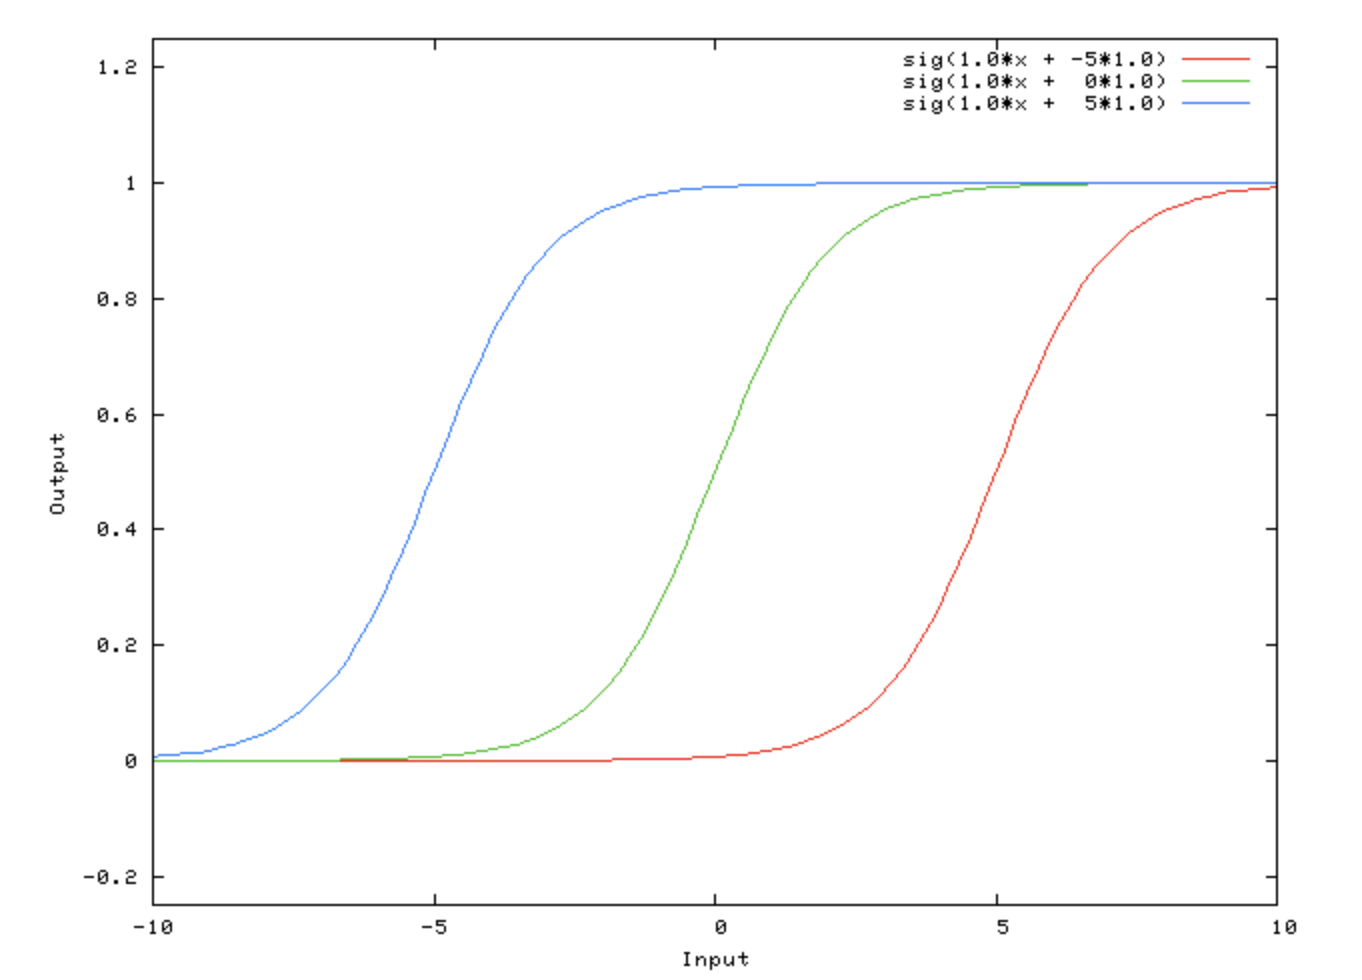